In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/checkdddd/checkpoint (1).pth
/kaggle/input/checkpoint-90/checkpoint_epoch_90.pth


In [1]:
import os 
import shutil
dataset_dir = '/kaggle/input/check510a'
working = '/kaggle/working/'
if not os.path.exists(working):
    os.makedirs(working)
def copy_tree(src,dst):
    for item in os.listdir(src):
        src_path = os.path.join(src,item)
        dst_path = os.path.join(dst,item)
        if os.path.isdir(src_path):
            if not os.path.exists(dst_path):
                os.makedirs(dst_path)
            copy_tree(src_path,dst_path)
        else:
            shutil.copy2(src_path,dst_path)

copy_tree(dataset_dir,working)
        

In [5]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import random
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.transforms import functional
from PIL import Image
import io

class AttackLayer(nn.Module):
    def __init__(self):
        super(AttackLayer, self).__init__()
        self.attacks= [
            self.jpeg_compress,self.add_gaussian_noise,self.rotate30,self.adjust_brightness2, self.crop_image,self.resize_image,self.adjust_brightness1,self.adjust_contrast,self.rotate90,self.adjust_hue,self.adjust_sharpness,self.no_op ]
        self.probabilities = [1.0 / len(self.attacks)] * len(self.attacks)
    def forward(self, img):
        # Apply a random attack to the image
        # attacks = [self.jpeg_compress, self.add_gaussian_noise,self.rotate30,self.adjust_brightness2, self.crop_image, self.resize_image,self.adjust_brightness1,self.adjust_contrast,self.rotate90,self.adjust_hue,self.adjust_sharpness]
        # attack = random.choice(attacks)
        # return attack(img)
        attack_index = torch.multinomial(torch.tensor(self.probabilities), 1).item()
        attack = self.attacks[attack_index]
        return attack(img)

    def jpeg_compress(self, img, quality=80):
        """
        Simulates JPEG compression on the input image.
        """
        compressed_images = []
        for i in range(img.size(0)): # Iterate over the batch
            single_img = img[i] # Get a single image from the batch
            single_img = T.ToPILImage()(single_img.cpu())  # Convert tensor to PIL image
            buffer = io.BytesIO()
            single_img.save(buffer, format="JPEG", quality=quality)  # Compress using JPEG
            compressed_img = Image.open(buffer)
            compressed_images.append(T.ToTensor()(compressed_img).to(img.device))  # Convert back to tensor and append to list
        
        return torch.stack(compressed_images) # Stack the compressed images back into a batch

    def add_gaussian_noise(self, img, std=0.02):
        """
        Adds Gaussian noise to the image.
        """
        noise = torch.randn(img.size()) * std
        noisy_img = img + noise.to(img.device)
        return torch.clamp(noisy_img, 0, 1)  # Keep values in range [0, 1]

    def crop_image(self, img, crop_size=24):
        """
        Crops the center of the image to a smaller size and resizes it back.
        """
        img = T.CenterCrop(crop_size)(img)
        img = T.Resize((32, 32))(img)  # Resize back to original size
        return img

    def resize_image(self, img, scale_factor=0.8):
        """
        Resizes the image to simulate resizing attacks.
        """
        size = int(32 * scale_factor)
        img = T.Resize(size)(img)
        img = T.Resize((32, 32))(img)  # Resize back to 32x32
        return img
    def rotate90(self,img,angle=90):
        """Rotat image by angle"""
        return functional.rotate(img,angle)
    def rotate30(self,img,angle=25):
        """Rotat image by angle"""
        return functional.rotate(img,angle)
    def adjust_brightness1(self,img,factor=0.5):
        return functional.adjust_brightness(img,factor)
    def adjust_contrast(self,img,factor=0.3):
        return functional.adjust_contrast(img,factor)
    def adjust_hue(self,img,factor=0.5):
        return functional.adjust_hue(img,factor)
    def adjust_sharpness(self,img,factor=1.2):
        return functional.adjust_sharpness(img,factor)
    def adjust_brightness2(self,img,factor=1.5):
        return functional.adjust_brightness(img,factor)
    def no_op(self, img):
        """
        No-operation attack: returns the input image unchanged.
        """
        return img
    
class StegNet(nn.Module):
    def __init__(self):
        super(StegNet, self).__init__()
        self.define_encoder()
        self.define_decoder()
        self.attacks = AttackLayer()

    def define_encoder(self):

        # layer1
        self.encoder_payload_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.encoder_source_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        # layer2
        self.encoder_payload_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.encoder_source_21 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
#         self.encoder_bn2 = nn.BatchNorm2d(32)

        # layer3
        self.encoder_payload_3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # layer4
        self.encoder_payload_4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encoder_source_41 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn4 = nn.BatchNorm2d(32)

        # layer5
        self.encoder_payload_5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # layer6
        self.encoder_payload_6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_6 = nn.Conv2d(192, 128, kernel_size=3, padding=1)
        self.encoder_source_61 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encoder_source_62 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn6 = nn.BatchNorm2d(32)

        # layer7
        self.encoder_payload_7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # layer8
        self.encoder_payload_8 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.encoder_source_81 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encoder_source_82 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn8 = nn.BatchNorm2d(32)

        # layer9
        self.encoder_source_9 = nn.Conv2d(32, 16, kernel_size=1)

        #layer10
        self.encoder_source_10 = nn.Conv2d(16, 8, kernel_size=1)

        #layer11
        self.encoder_source_11 = nn.Conv2d(8, 3, kernel_size=1)


    def define_decoder(self):

        self.decoder_layers1 = nn.Conv2d(3, 256, kernel_size=3, padding=1)
        self.decoder_layers2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
#         self.decoder_bn2 = nn.BatchNorm2d(64)

        self.decoder_layers3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.decoder_layers4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.decoder_bn4 = nn.BatchNorm2d(32)

        self.decoder_layers5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        # payload_decoder
        self.decoder_payload1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.decoder_payload2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        self.decoder_payload3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.decoder_payload4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)

        self.decoder_payload5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.decoder_payload6 = nn.Conv2d(3, 1, kernel_size=3, padding=1)


        # source_decoder
        self.decoder_source1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.decoder_source2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        self.decoder_source3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.decoder_source4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)

        self.decoder_source5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.decoder_source6 = nn.Conv2d(3, 3, kernel_size=3, padding=1)


    def forward(self, x):

        source, payload = x

        s = source.view((-1, 3, 32, 32))
        p = payload.view((-1, 1, 32, 32))

        # --------------------------- Encoder -------------------------
        # layer1
        p = F.relu(self.encoder_payload_1(p))
        s = F.relu(self.encoder_source_1(s))

        #layer2
        p = F.relu(self.encoder_payload_2(p))
        s1 = torch.cat((s, p), 1) # 64
        s = F.relu(self.encoder_source_2(s1))
        s = F.relu(self.encoder_source_21(s1))
#         s = self.encoder_bn2(s)

        # layer3
        p = F.relu(self.encoder_payload_3(p))
        s = F.relu(self.encoder_source_3(s))

        #layer4
        p = F.relu(self.encoder_payload_4(p))
        s2 = torch.cat((s, p, s1), 1) # 128
        s = F.relu(self.encoder_source_4(s2))
        s = F.relu(self.encoder_source_41(s))
#         s = self.encoder_bn4(s)

        # layer5
        p = F.relu(self.encoder_payload_5(p))
        s = F.relu(self.encoder_source_5(s))

        #layer6
        p = F.relu(self.encoder_payload_6(p))
        s3 = torch.cat((s, p, s2), 1) # 192
        s = F.relu(self.encoder_source_6(s3))
        s = F.relu(self.encoder_source_61(s))
        s = F.relu(self.encoder_source_62(s))
#         s = self.encoder_bn6(s)

        # layer7
        p = F.relu(self.encoder_payload_7(p))
        s = F.relu(self.encoder_source_7(s))

        #layer8
        p = F.relu(self.encoder_payload_8(p))
        s4 = torch.cat((s, p, s3), 1)
        s = F.relu(self.encoder_source_8(s4))
        s = F.relu(self.encoder_source_81(s))
        s = F.relu(self.encoder_source_82(s))
#         s = self.encoder_bn8(s)

        #layer9
        s = F.relu(self.encoder_source_9(s))

        #layer10
        s = F.relu(self.encoder_source_10(s))

        #layer11
        encoder_output = self.encoder_source_11(s)
        # print("Enc Out:",encoder_output.shape)
        attacked_output = self.attacks(encoder_output)
        # print("Attack:",attacked_output.shape)
        # attck_out = attacked_output.view(-1, 3, 32, 32)

        # -------------------- Decoder --------------------------

        # d = encoder_output.view(-1, 3, 32, 32)
        d = attacked_output.reshape(-1, 3, 32, 32)

        #layer1
        d = F.relu(self.decoder_layers1(d))
        d = F.relu(self.decoder_layers2(d))
#         d = self.decoder_bn2(d)

        #layer3
        d = F.relu(self.decoder_layers3(d))
        d = F.relu(self.decoder_layers4(d))
#         d = self.decoder_bn4(d)

        init_d = F.relu(self.decoder_layers5(d))

        # ---------------- decoder_payload ----------------

        # layer 1 & 2
        d = F.relu(self.decoder_payload1(init_d))
        d = F.relu(self.decoder_payload2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_payload3(d))
        d = F.relu(self.decoder_payload4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_payload5(d))
        decoded_payload = self.decoder_payload6(d)

        # ---------------- decoder_source ----------------

        # layer 1 & 2
        d = F.relu(self.decoder_source1(init_d))
        d = F.relu(self.decoder_source2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_source3(d))
        d = F.relu(self.decoder_source4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_source5(d))
        decoded_source = self.decoder_source6(d)

        return encoder_output, attacked_output,decoded_payload, decoded_source

model = StegNet().to(device)
model

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

metric = nn.L1Loss()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# from tqdm import tqdm
# Custom Dataset to combine CIFAR-10 as cover images and MNIST as payload images
class WatermarkDataset(Dataset):
    def __init__(self, source_data, payload_data):
        self.source_data = source_data
        self.payload_data = payload_data

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        source_image = self.source_data[idx]
        payload_image = self.payload_data[idx]
        return source_image, payload_image
# class WatermarkDataset(Dataset):
#     def __init__(self, source_data, payload_data):
#         self.source_data = source_data
#         self.payload_data = payload_data

#     def __len__(self):
#         return len(self.source_data)

#     def __getitem__(self, idx):
#         source_image, _ = self.source_data[idx]  # Ignore CIFAR-10 labels
#         payload_image, _ = self.payload_data[idx]  # Ignore FashionMNIST labels
#         return source_image, payload_image
# Helper function to plot images
def plot_images(source_image, watermarked_image, decoded_image, watermark_image,decoded_watermark_image ,idx):
    source_image = source_image.detach().cpu().numpy().transpose(1, 2, 0)
    watermarked_image = watermarked_image.detach().cpu().numpy().transpose(1, 2, 0)
    decoded_image = decoded_image.detach().cpu().numpy().transpose(1, 2, 0)
    watermark_image = watermark_image.detach().cpu().numpy().squeeze()
    decoded_watermark_image = decoded_watermark_image.detach().cpu().numpy().squeeze()

    fig, axs = plt.subplots(1, 5, figsize=(16, 4))

    axs[0].imshow(source_image)
    axs[0].set_title(f'Source Image {idx}')

    axs[1].imshow(watermarked_image)
    axs[1].set_title(f'Watermarked Image {idx}')

    axs[2].imshow(decoded_image)
    axs[2].set_title(f'Attacked Image {idx}')

    axs[3].imshow(watermark_image, cmap='gray')
    axs[3].set_title(f'Watermark Image {idx}')

    axs[4].imshow(decoded_watermark_image, cmap='gray')
    axs[4].set_title(f'Decoded Watermark {idx}')

    plt.show()

# Load CIFAR-10 dataset for source images
transform_cifar = transforms.Compose([transforms.ToTensor()])
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)

# Load MNIST dataset for payload images and resize them to 32x32
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize MNIST (28x28) to CIFAR-10 size (32x32)
    transforms.Grayscale(num_output_channels=1),  # Ensure MNIST is grayscale
    transforms.ToTensor()
])
# mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
fashionmnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_mnist)
# Ensure both datasets have the same length
min_len = min(len(cifar_train), len(fashionmnist_train))
cifar_train = torch.utils.data.Subset(cifar_train, list(range(min_len)))
# mnist_train = torch.utils.data.Subset(mnist_train, list(range(min_len)))
fashionmnist_train = torch.utils.data.Subset(fashionmnist_train, list(range(min_len)))
# Create datasets and data loaders
batch_size = 32
train_dataset = WatermarkDataset(cifar_train, fashionmnist_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

cuda:0
Files already downloaded and verified


100%|██████████| 1563/1563 [01:47<00:00, 14.47it/s]


Epoch 1, Train loss: 0.07643636775227479


100%|██████████| 1563/1563 [01:47<00:00, 14.53it/s]


Epoch 2, Train loss: 0.04051821489096813
Epoch 2, Iteration 1563 - Visualizing Images


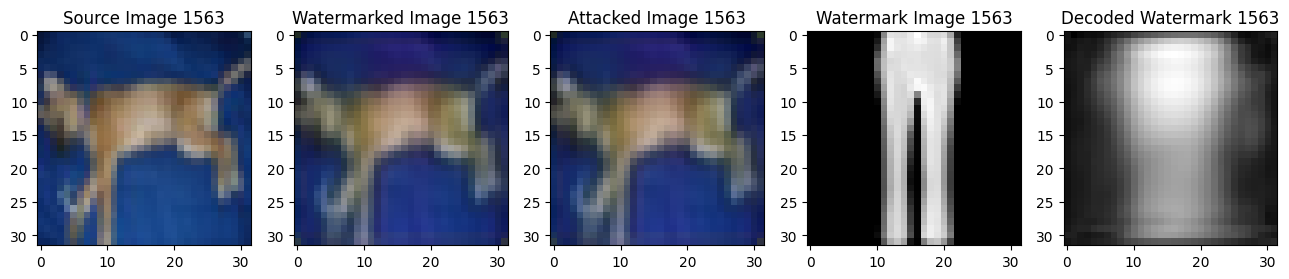

100%|██████████| 1563/1563 [01:48<00:00, 14.41it/s]


Epoch 3, Train loss: 0.03468960474626002


100%|██████████| 1563/1563 [01:47<00:00, 14.50it/s]


Epoch 4, Train loss: 0.03408779524164233
Epoch 4, Iteration 1563 - Visualizing Images


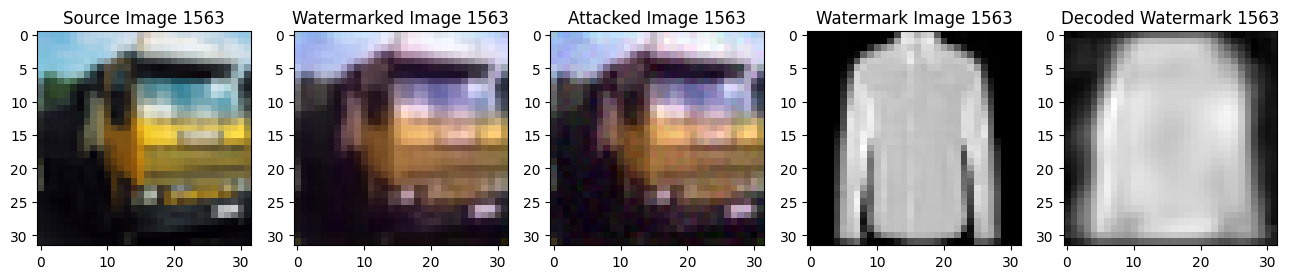

100%|██████████| 1563/1563 [01:48<00:00, 14.44it/s]


Epoch 5, Train loss: 0.032651513699925985


100%|██████████| 1563/1563 [01:47<00:00, 14.47it/s]


Epoch 6, Train loss: 0.031090165099626026
Epoch 6, Iteration 1563 - Visualizing Images


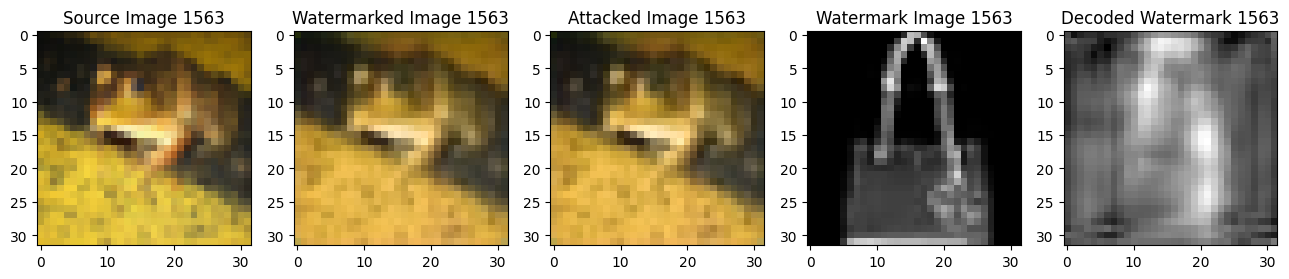

100%|██████████| 1563/1563 [01:48<00:00, 14.44it/s]


Epoch 7, Train loss: 0.029406741078554517


100%|██████████| 1563/1563 [01:48<00:00, 14.45it/s]


Epoch 8, Train loss: 0.030294059853528888
Epoch 8, Iteration 1563 - Visualizing Images


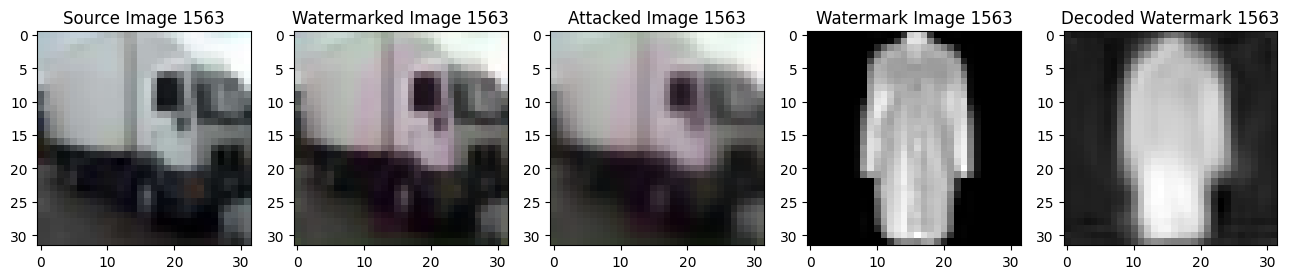

100%|██████████| 1563/1563 [01:47<00:00, 14.51it/s]


Epoch 9, Train loss: 0.029789009440442403


100%|██████████| 1563/1563 [01:47<00:00, 14.48it/s]


Epoch 10, Train loss: 0.029925789721149256
Epoch 10, Iteration 1563 - Visualizing Images


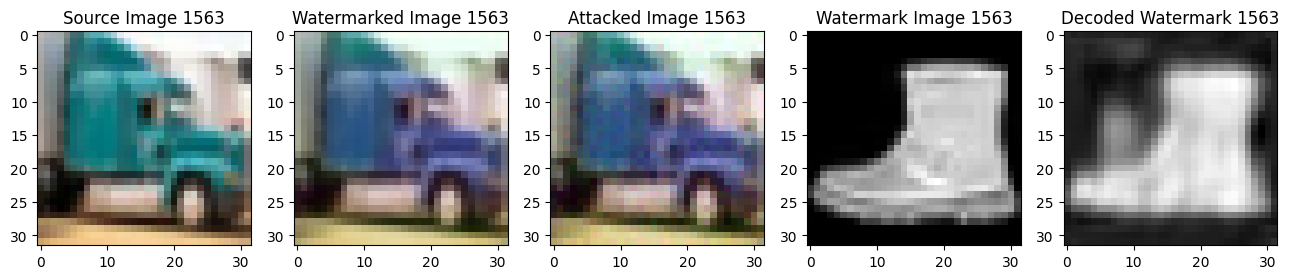

100%|██████████| 1563/1563 [01:47<00:00, 14.51it/s]


Epoch 11, Train loss: 0.030056569207923264


100%|██████████| 1563/1563 [01:47<00:00, 14.54it/s]


Epoch 12, Train loss: 0.029851826568481513
Epoch 12, Iteration 1563 - Visualizing Images


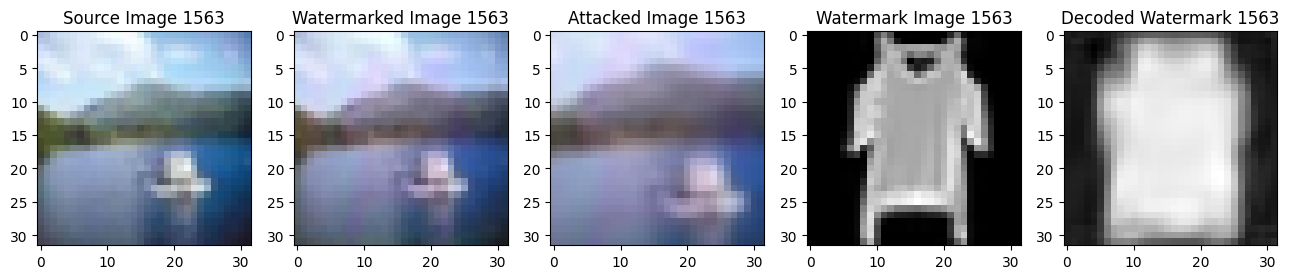

100%|██████████| 1563/1563 [01:47<00:00, 14.52it/s]


Epoch 13, Train loss: 0.02929295170086931


100%|██████████| 1563/1563 [01:47<00:00, 14.50it/s]


Epoch 14, Train loss: 0.02820771177116393
Epoch 14, Iteration 1563 - Visualizing Images


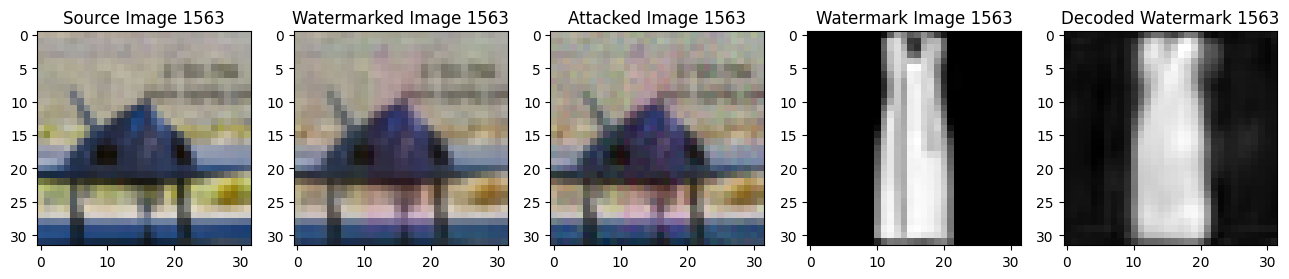

100%|██████████| 1563/1563 [01:47<00:00, 14.53it/s]


Epoch 16, Train loss: 0.02850094391122432
Epoch 16, Iteration 1563 - Visualizing Images


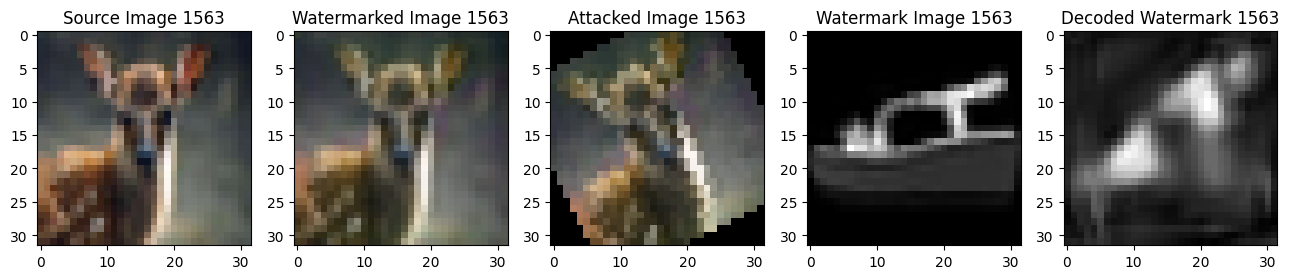

100%|██████████| 1563/1563 [01:47<00:00, 14.52it/s]


Epoch 17, Train loss: 0.02708554252480429


100%|██████████| 1563/1563 [01:47<00:00, 14.51it/s]


Epoch 18, Train loss: 0.026848957328523868
Epoch 18, Iteration 1563 - Visualizing Images


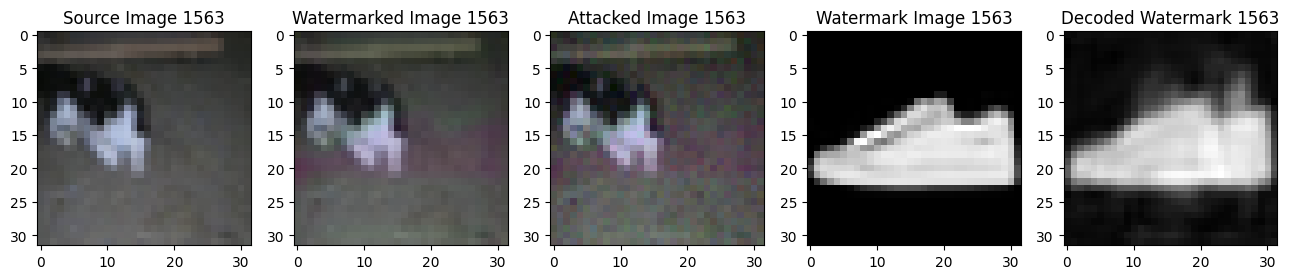

100%|██████████| 1563/1563 [01:47<00:00, 14.53it/s]


Epoch 20, Train loss: 0.027963020943816672
Epoch 20, Iteration 1563 - Visualizing Images


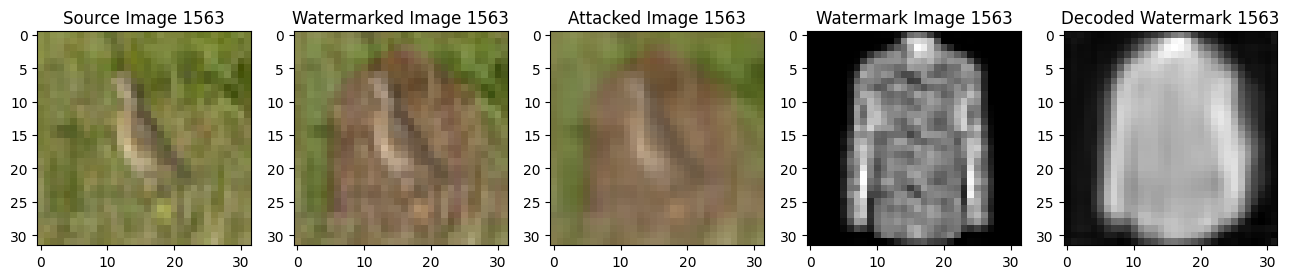

100%|██████████| 1563/1563 [01:47<00:00, 14.57it/s]


Epoch 21, Train loss: 0.027588169918689336


100%|██████████| 1563/1563 [01:47<00:00, 14.52it/s]


Epoch 22, Train loss: 0.027895754619256634
Epoch 22, Iteration 1563 - Visualizing Images


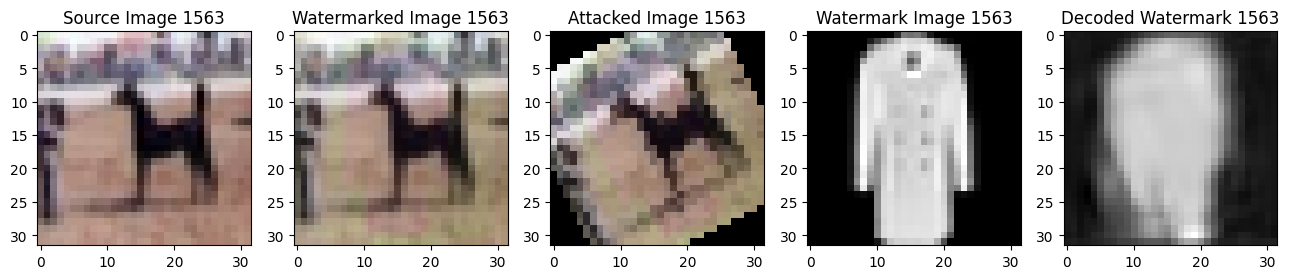

100%|██████████| 1563/1563 [01:47<00:00, 14.51it/s]


Epoch 24, Train loss: 0.027587622350173563
Epoch 24, Iteration 1563 - Visualizing Images


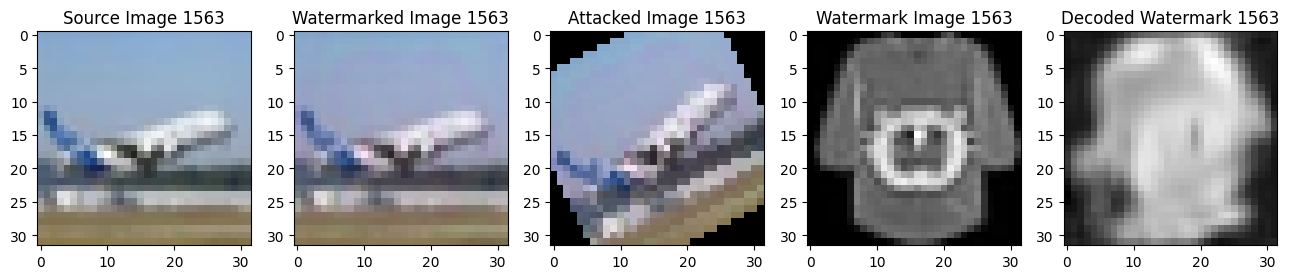

100%|██████████| 1563/1563 [01:47<00:00, 14.54it/s]


Epoch 25, Train loss: 0.027961296226915094


100%|██████████| 1563/1563 [01:47<00:00, 14.53it/s]


Epoch 26, Train loss: 0.026612035917941663
Epoch 26, Iteration 1563 - Visualizing Images


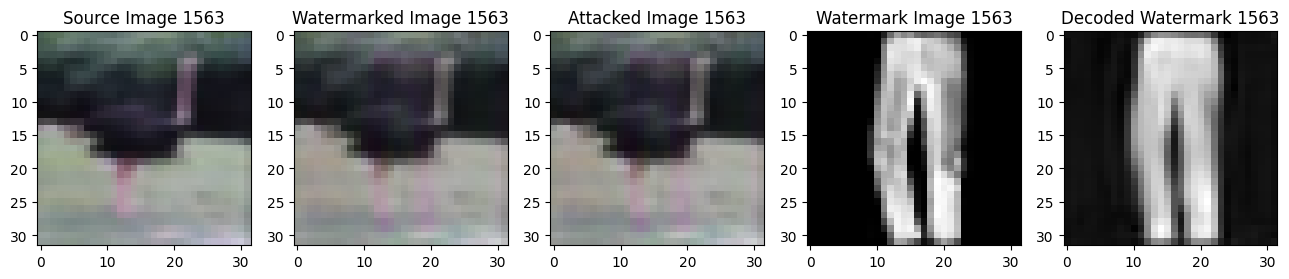

100%|██████████| 1563/1563 [01:47<00:00, 14.48it/s]


Epoch 27, Train loss: 0.026440676038200543


100%|██████████| 1563/1563 [01:47<00:00, 14.51it/s]


Epoch 29, Train loss: 0.02573241918408553


100%|██████████| 1563/1563 [01:47<00:00, 14.54it/s]


Epoch 30, Train loss: 0.025873329505915452
Epoch 30, Iteration 1563 - Visualizing Images


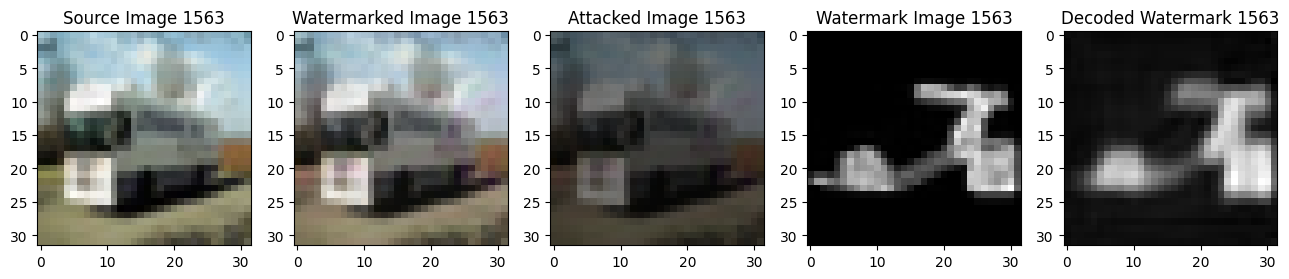

100%|██████████| 1563/1563 [01:47<00:00, 14.53it/s]


Epoch 31, Train loss: 0.026429720428222295


100%|██████████| 1563/1563 [01:47<00:00, 14.53it/s]


Epoch 33, Train loss: 0.026309165088114254


100%|██████████| 1563/1563 [01:47<00:00, 14.51it/s]


Epoch 34, Train loss: 0.026989849960289643
Epoch 34, Iteration 1563 - Visualizing Images


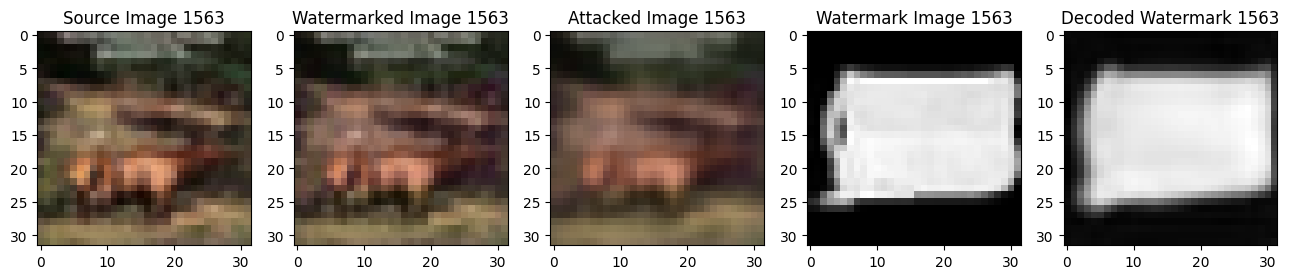

100%|██████████| 1563/1563 [01:47<00:00, 14.55it/s]


Epoch 35, Train loss: 0.026600403505778483


100%|██████████| 1563/1563 [01:47<00:00, 14.56it/s]


Epoch 36, Train loss: 0.026241924884530667
Epoch 36, Iteration 1563 - Visualizing Images


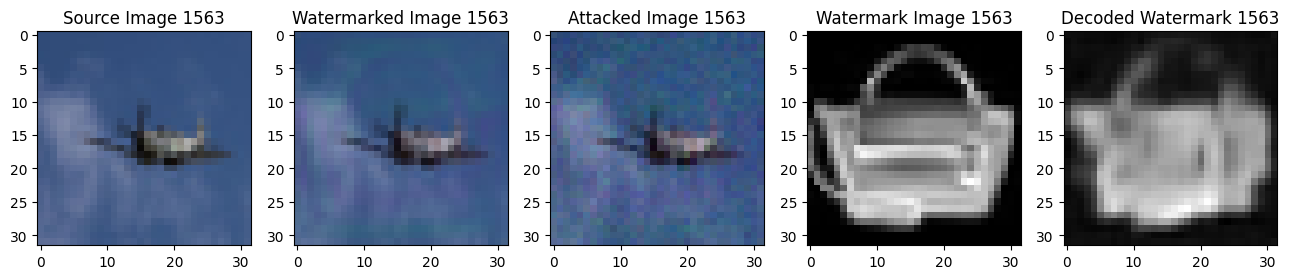

 87%|████████▋ | 1362/1563 [01:33<00:13, 14.64it/s]

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import logging
from tqdm import tqdm
import os

# Setup logging
logging.basicConfig(
    filename='training_log.log',  # Log file to write
    level=logging.INFO,           # Log level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
)

# Function to save model checkpoints
def save_checkpoint(model, optimizer, epoch, filepath='/kaggle/working/'):
    os.makedirs(filepath,exist_ok=True)
    fp = os.path.join(filepath,f'checkpoint_epoch_{epoch}.pth')
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, fp)
    logging.info(f"Checkpoint saved at epoch {epoch} to {fp}")

# Function to load checkpoint and resume training
def load_checkpoint(filepath='checkpoint_epoch_510 (1).pth'):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    logging.info(f"Checkpoint loaded from {filepath}, resuming from epoch {epoch}")
    return epoch

# Initialize model, optimizer, and loss criterion
model = model.cuda()  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop parameters
epochs = 1000
flat_source_size = 32 * 32 * 3
flat_payload_size = 32 * 32
save_interval = 30  # Save checkpoint every 30 epochs

# Check if a checkpoint exists and load it to resume training
start_epoch = 0
checkpoint_path = ''
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(filepath=checkpoint_path)

# Training loop
for epoch in range(start_epoch, epochs):
    model.train()
    train_loss = 0.0

    for idx, (s, p) in enumerate(tqdm(train_loader)):
        # CIFAR-10 gives (image, label), and MNIST gives (image, label) - we only need the images
        s, _ = s  # Take only images from CIFAR-10 dataset
        p, _ = p  # Take only images from MNIST dataset

        s, p = s.cuda(), p.cuda()  # Move data to GPU

        optimizer.zero_grad()

        # Forward pass
        e_out,attck_out, dp_out, ds_out = model.forward((s, p))

        # Compute losses
        w_loss = criterion(e_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
        e_loss = criterion(attck_out.reshape((-1, flat_source_size)), s.reshape((-1, flat_source_size)))
        dp_loss = criterion(dp_out.reshape((-1, flat_payload_size)), p.reshape((-1, flat_payload_size)))
        ds_loss = criterion(ds_out.reshape((-1, flat_source_size)), s.reshape((-1, flat_source_size)))
        loss = 0.7*e_loss + 0.2*dp_loss+ (1*1.5*w_loss)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Log epoch loss
    epoch_loss = train_loss / len(train_loader)
    logging.info(f"Epoch {epoch + 1}, Train loss: {epoch_loss}")
    print(f"Epoch {epoch + 1}, Train loss: {epoch_loss}")
#     check = 'check'
    # Save checkpoint every 30 epochs
    if (epoch + 1) % save_interval == 0:
        save_checkpoint(model, optimizer, epoch + 1 )

    # Visualize images every 20 epochs
    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}, Iteration {idx + 1} - Visualizing Images')
        plot_images(s[0], e_out[0], attck_out[0], p[0], dp_out[0], idx + 1)

# Save the final model after training
torch.save(model.state_dict(), 'model_final.pth')
logging.info("Training completed, final model saved to 'model_final.pth'")


In [7]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import random
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.transforms import functional
from PIL import Image
import io

class AttackLayer(nn.Module):
    def __init__(self):
        super(AttackLayer, self).__init__()
        self.attacks= [
            self.jpeg_compress,self.add_gaussian_noise,self.rotate30,self.adjust_brightness2, self.crop_image,self.resize_image,self.adjust_brightness1,self.adjust_contrast,self.rotate90,self.adjust_hue,self.adjust_sharpness,self.no_op ]
        self.probabilities = [1.0 / len(self.attacks)] * len(self.attacks)
    def forward(self, img):
        # Apply a random attack to the image
        # attacks = [self.jpeg_compress, self.add_gaussian_noise,self.rotate30,self.adjust_brightness2, self.crop_image, self.resize_image,self.adjust_brightness1,self.adjust_contrast,self.rotate90,self.adjust_hue,self.adjust_sharpness]
        # attack = random.choice(attacks)
        # return attack(img)
        attack_index = torch.multinomial(torch.tensor(self.probabilities), 1).item()
        attack = self.attacks[attack_index]
        return attack(img)

    def jpeg_compress(self, img, quality=80):
        """
        Simulates JPEG compression on the input image.
        """
        compressed_images = []
        for i in range(img.size(0)): # Iterate over the batch
            single_img = img[i] # Get a single image from the batch
            single_img = T.ToPILImage()(single_img.cpu())  # Convert tensor to PIL image
            buffer = io.BytesIO()
            single_img.save(buffer, format="JPEG", quality=quality)  # Compress using JPEG
            compressed_img = Image.open(buffer)
            compressed_images.append(T.ToTensor()(compressed_img).to(img.device))  # Convert back to tensor and append to list
        
        return torch.stack(compressed_images) # Stack the compressed images back into a batch

    def add_gaussian_noise(self, img, std=0.02):
        """
        Adds Gaussian noise to the image.
        """
        noise = torch.randn(img.size()) * std
        noisy_img = img + noise.to(img.device)
        return torch.clamp(noisy_img, 0, 1)  # Keep values in range [0, 1]

    def crop_image(self, img, crop_size=24):
        """
        Crops the center of the image to a smaller size and resizes it back.
        """
        img = T.CenterCrop(crop_size)(img)
        img = T.Resize((32, 32))(img)  # Resize back to original size
        return img

    def resize_image(self, img, scale_factor=0.8):
        """
        Resizes the image to simulate resizing attacks.
        """
        size = int(32 * scale_factor)
        img = T.Resize(size)(img)
        img = T.Resize((32, 32))(img)  # Resize back to 32x32
        return img
    def rotate90(self,img,angle=90):
        """Rotat image by angle"""
        return functional.rotate(img,angle)
    def rotate30(self,img,angle=25):
        """Rotat image by angle"""
        return functional.rotate(img,angle)
    def adjust_brightness1(self,img,factor=0.5):
        return functional.adjust_brightness(img,factor)
    def adjust_contrast(self,img,factor=0.3):
        return functional.adjust_contrast(img,factor)
    def adjust_hue(self,img,factor=0.5):
        return functional.adjust_hue(img,factor)
    def adjust_sharpness(self,img,factor=1.2):
        return functional.adjust_sharpness(img,factor)
    def adjust_brightness2(self,img,factor=1.5):
        return functional.adjust_brightness(img,factor)
    def no_op(self, img):
        """
        No-operation attack: returns the input image unchanged.
        """
        return img
    
class StegNet(nn.Module):
    def __init__(self):
        super(StegNet, self).__init__()
        self.define_encoder()
        self.define_decoder()
        self.attacks = AttackLayer()

    def define_encoder(self):

        # layer1
        self.encoder_payload_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.encoder_source_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        # layer2
        self.encoder_payload_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.encoder_source_21 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
#         self.encoder_bn2 = nn.BatchNorm2d(32)

        # layer3
        self.encoder_payload_3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # layer4
        self.encoder_payload_4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encoder_source_41 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn4 = nn.BatchNorm2d(32)

        # layer5
        self.encoder_payload_5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # layer6
        self.encoder_payload_6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_6 = nn.Conv2d(192, 128, kernel_size=3, padding=1)
        self.encoder_source_61 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encoder_source_62 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn6 = nn.BatchNorm2d(32)

        # layer7
        self.encoder_payload_7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # layer8
        self.encoder_payload_8 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.encoder_source_81 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encoder_source_82 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn8 = nn.BatchNorm2d(32)

        # layer9
        self.encoder_source_9 = nn.Conv2d(32, 16, kernel_size=1)

        #layer10
        self.encoder_source_10 = nn.Conv2d(16, 8, kernel_size=1)

        #layer11
        self.encoder_source_11 = nn.Conv2d(8, 3, kernel_size=1)


    def define_decoder(self):

        self.decoder_layers1 = nn.Conv2d(3, 256, kernel_size=3, padding=1)
        self.decoder_layers2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
#         self.decoder_bn2 = nn.BatchNorm2d(64)

        self.decoder_layers3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.decoder_layers4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.decoder_bn4 = nn.BatchNorm2d(32)

        self.decoder_layers5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        # payload_decoder
        self.decoder_payload1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.decoder_payload2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        self.decoder_payload3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.decoder_payload4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)

        self.decoder_payload5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.decoder_payload6 = nn.Conv2d(3, 1, kernel_size=3, padding=1)


        # source_decoder
        self.decoder_source1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.decoder_source2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        self.decoder_source3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.decoder_source4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)

        self.decoder_source5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.decoder_source6 = nn.Conv2d(3, 3, kernel_size=3, padding=1)


    def forward(self, x):

        source, payload = x

        s = source.view((-1, 3, 32, 32))
        p = payload.view((-1, 1, 32, 32))

        # --------------------------- Encoder -------------------------
        # layer1
        p = F.relu(self.encoder_payload_1(p))
        s = F.relu(self.encoder_source_1(s))

        #layer2
        p = F.relu(self.encoder_payload_2(p))
        s1 = torch.cat((s, p), 1) # 64
        s = F.relu(self.encoder_source_2(s1))
        s = F.relu(self.encoder_source_21(s1))
#         s = self.encoder_bn2(s)

        # layer3
        p = F.relu(self.encoder_payload_3(p))
        s = F.relu(self.encoder_source_3(s))

        #layer4
        p = F.relu(self.encoder_payload_4(p))
        s2 = torch.cat((s, p, s1), 1) # 128
        s = F.relu(self.encoder_source_4(s2))
        s = F.relu(self.encoder_source_41(s))
#         s = self.encoder_bn4(s)

        # layer5
        p = F.relu(self.encoder_payload_5(p))
        s = F.relu(self.encoder_source_5(s))

        #layer6
        p = F.relu(self.encoder_payload_6(p))
        s3 = torch.cat((s, p, s2), 1) # 192
        s = F.relu(self.encoder_source_6(s3))
        s = F.relu(self.encoder_source_61(s))
        s = F.relu(self.encoder_source_62(s))
#         s = self.encoder_bn6(s)

        # layer7
        p = F.relu(self.encoder_payload_7(p))
        s = F.relu(self.encoder_source_7(s))

        #layer8
        p = F.relu(self.encoder_payload_8(p))
        s4 = torch.cat((s, p, s3), 1)
        s = F.relu(self.encoder_source_8(s4))
        s = F.relu(self.encoder_source_81(s))
        s = F.relu(self.encoder_source_82(s))
#         s = self.encoder_bn8(s)

        #layer9
        s = F.relu(self.encoder_source_9(s))

        #layer10
        s = F.relu(self.encoder_source_10(s))

        #layer11
        encoder_output = self.encoder_source_11(s)
        # print("Enc Out:",encoder_output.shape)
        attacked_output = self.attacks(encoder_output)
        # print("Attack:",attacked_output.shape)
        # attck_out = attacked_output.view(-1, 3, 32, 32)

        # -------------------- Decoder --------------------------

        # d = encoder_output.view(-1, 3, 32, 32)
        d = attacked_output.reshape(-1, 3, 32, 32)

        #layer1
        d = F.relu(self.decoder_layers1(d))
        d = F.relu(self.decoder_layers2(d))
#         d = self.decoder_bn2(d)

        #layer3
        d = F.relu(self.decoder_layers3(d))
        d = F.relu(self.decoder_layers4(d))
#         d = self.decoder_bn4(d)

        init_d = F.relu(self.decoder_layers5(d))

        # ---------------- decoder_payload ----------------

        # layer 1 & 2
        d = F.relu(self.decoder_payload1(init_d))
        d = F.relu(self.decoder_payload2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_payload3(d))
        d = F.relu(self.decoder_payload4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_payload5(d))
        decoded_payload = self.decoder_payload6(d)

        # ---------------- decoder_source ----------------

        # layer 1 & 2
        d = F.relu(self.decoder_source1(init_d))
        d = F.relu(self.decoder_source2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_source3(d))
        d = F.relu(self.decoder_source4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_source5(d))
        decoded_source = self.decoder_source6(d)

        return encoder_output, attacked_output,decoded_payload, decoded_source

model = StegNet().to(device)
state_dict = torch.load('/kaggle/input/check510/checkpoint_epoch_510.pth')["model_state_dict"]
model.load_state_dict(state_dict)
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.decoder_layers1.parameters():
#     param.requires_grad = True
# for param in model.decoder_layers2.parameters():
#     param.requires_grad = True
# for param in model.decoder_layers3.parameters():
#     param.requires_grad = True
# for param in model.decoder_layers4.parameters():
#     param.requires_grad = True
# for param in model.decoder_layers5.parameters():
#     param.requires_grad = True
# for param in model.decoder_payload1.parameters():
#     param.requires_grad = True
# for param in model.decoder_payload2.parameters():
#     param.requires_grad = True
# for param in model.decoder_payload3.parameters():
#     param.requires_grad = True
# for param in model.decoder_payload4.parameters():
#     param.requires_grad = True
# for param in model.decoder_payload5.parameters():
#     param.requires_grad = True
# for param in model.decoder_payload6.parameters():
#     param.requires_grad = True

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = nn.L1Loss()
model


cuda:0


<ipython-input-7-7ec82907eef2>:302: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/kaggle/input/check510/checkpoint_epoch_510.pth')["model_state_dic

StegNet(
  (encoder_payload_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_21): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_41): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
# Define a custom dataset (assuming image paths are available)

class WatermarkedImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image  # Only returning the watermarked image

# Directory containing watermarked images
image_dir = "/kaggle/input/watermarked-image/kaggle/working/outputs/txt2img-samples/sampleswater50k"  # Change this to your actual dataset path

# Define transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize if required
    transforms.ToTensor(),  # Convert to PyTorch tensor
])

# Create dataset and dataloader
dataset = WatermarkedImageDataset(image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
# Model setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze Encoder (Assuming Encoder-Decoder Model)
for param in model.parameters():
    param.requires_grad = False
for param in [
    model.decoder_layers1, model.decoder_layers2, 
    model.decoder_layers3, model.decoder_layers4, 
    model.decoder_layers5, model.decoder_payload1, model.decoder_payload2,
    model.decoder_payload3, model.decoder_payload4, 
    model.decoder_payload5, model.decoder_payload6,
    model.decoder_source1, model.decoder_source2,
    model.decoder_source3, model.decoder_source4,
    model.decoder_source5, model.decoder_source6
]:
    for p in param.parameters():
        p.requires_grad = True

# Define loss function (MSE for self-supervised training)
criterion = nn.MSELoss()

# Optimizer (Only for decoder)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in dataloader:
        watermarked_images = batch.to(device)  # Only watermarked images are available

        optimizer.zero_grad()
        
        # Forward pass
        _, _, decoded_watermark, _ = model((None, watermarked_images))  # No cover image

        # Self-supervised loss: Assume the watermark should be extracted
        loss = criterion(decoded_watermark, decoded_watermark.detach())  # Autoencoder-like
        
        # Backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


AttributeError: 'NoneType' object has no attribute 'view'